In [1]:
import sympy
import copy
import sys
import scipy
import numpy as np
from sympy import Matrix, symbols, BlockMatrix, transpose
from sympy import matrix_multiply_elementwise as mult_e
sympy.init_printing(pretty_print=True, use_latex=True)
from sympy import Matrix, symbols, BlockMatrix, transpose
from sympy import MatrixSymbol, simplify, Array, eye
from sympy import init_printing
init_printing()
from sympy.physics.quantum import TensorProduct
from scipy.linalg import circulant
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from nose.tools import assert_equal
import sys
from IPython.display import clear_output
import itertools
import functools
import time
import pickle
from scipy.integrate import solve_ivp
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import pandas as pd

 ## Analytically (sympy):
 - Create a system of ODEs describing the dynamics of coupled Stuart Landau oscillators with arbitrary parameters
 - Find its Jacobian
 - Evaluate that Jacobian at a specific state
 - Block diagonalize (optional)

## Numerically (sympy to numpy):
 - Evaluate the (block diagonal) Jacobian for given parameters
 - Obtain the relevant eigenvalues, largest real part determines linear stability
   - Time-dependent Jacobian needs to be treated differently, not implemented yet
 - Plot stability for different parameter ranges

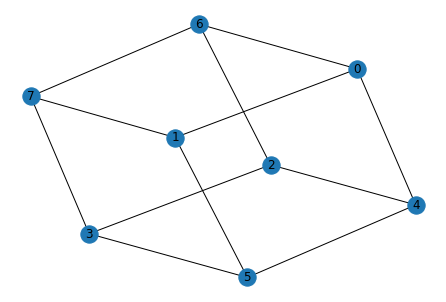

In [2]:
import networkx as nx
A = np.array([[0, 1, 0, 0, 1, 0, 1, 0],
              [1, 0, 0, 0, 0, 1, 0, 1],
              [0, 0, 0, 1, 1, 0, 1, 0],
              [0, 0, 1, 0, 0, 1, 0, 1],
              [1, 0, 1, 0, 0, 1, 0, 0],
              [0, 1, 0, 1, 1, 0, 0, 0],
              [1, 0, 1, 0, 0, 0, 0, 1],
              [0, 1, 0, 1, 0, 0, 1, 0]])
G = nx.from_numpy_matrix(A)
nx.draw(G, with_labels = True)

In [3]:
class JacobianAnalytic():
    """
    Class to create a Jacobian for an arbitrary network of Stuart Landau oscillators.
    
    Attributes:
        n_nodes: int (default 8)
            number of nodes in the network
        adj_matrix: sympy Matrix
            adjacency matrix
        coupling_type: {'A', 'L'} (default 'L')
            adjacency or Laplacian coupling 
    """
    def __init__(self, adj_matrix, n_nodes=8, coupling_type='L', **kwargs):
        self.__dict__.update(kwargs)
        self.n_nodes = n_nodes
        self.coupling_type = coupling_type
        self.adj = np.array(adj_matrix)
        
        self.t = symbols(r't')
        self.var_names = ['r', 'theta']
                 
        self.vars = {}
        for name in self.var_names:
            self.vars[name] = Matrix(symbols([r'' + name + '_' + str(i)
                                            for i in range(self.n_nodes)]))

        self.param_names_v = ['lambda', 'omega']
        self.param_names_m = ['sigma', 'beta']
        
        self.params = {} 
        for name in self.param_names_v:
            self.params[name] = Matrix(symbols([r'' + name + '_' + str(i)
                                       for i in range(self.n_nodes)]))
        for name in self.param_names_m:
            self.params[name] = Matrix(sympy.zeros(self.n_nodes))
            for i in range(self.n_nodes):
                for j in range(self.n_nodes):
                    self.params[name][i, j] = symbols(r'' + name + '_' + str(i) + r'_'+str(j))
                    
        self.sl_ode()
        self.jacobian_eval()
        
    @classmethod
    def eight_node_cube(self, n_nodes=8, coupling_type='A'):
        """
        Method initializing a cube of oscillators
        
        Parameters:
            n_nodes: int (default 8)
                number of nodes in the network
            coupling_type: {'A', 'L'} (default 'A')
                coupling type
        """
        adj_matrix = Matrix([[0, 1, 0, 0, 1, 0, 1, 0],
                             [1, 0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 1, 0, 1, 0],
                             [0, 0, 1, 0, 0, 1, 0, 1],
                             [1, 0, 1, 0, 0, 1, 0, 0],
                             [0, 1, 0, 1, 1, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0, 1],
                             [0, 1, 0, 1, 0, 0, 1, 0]])
        if coupling_type == 'L':
            adj_matrix = Matrix(adj_matrix -  Matrix(np.sum(adj_matrix, axis=0) * np.eye(n_nodes)))
        return self(adj_matrix=adj_matrix)
    
    @classmethod
    def eight_node_cube_L(self, n_nodes=8, coupling_type='A'):
        """Method initializing a cube of oscillators"""
        adj_matrix = Matrix([[0, 0, 0, 0, 1, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 1, 0, 1, 0],
                             [0, 0, 1, 0, 0, 1, 0, 1],
                             [1, 0, 1, 0, 0, 1, 0, 0],
                             [0, 1, 0, 1, 1, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0, 1],
                             [0, 1, 0, 1, 0, 0, 1, 0]])
        if coupling_type == 'L':
            adj_matrix = Matrix(adj_matrix -  Matrix(np.sum(adj_matrix, axis=0) * np.eye(n_nodes)))
        return self(adj_matrix=adj_matrix)
    
    @classmethod
    def eight_node_cube_A(self, n_nodes=8, coupling_type='A'):
        """Method initializing a cube of oscillators"""
        adj_matrix = Matrix([[0, 1, 0, 0, 1, 1, 1, 1],
                             [1, 0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 1, 1, 1, 1],
                             [0, 0, 1, 0, 0, 1, 0, 1],
                             [1, 0, 1, 0, 0, 1, 0, 0],
                             [1, 1, 1, 1, 1, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0, 1],
                             [1, 1, 1, 1, 0, 0, 1, 0]])
        if coupling_type == 'L':
            adj_matrix = Matrix(adj_matrix -  Matrix(np.sum(adj_matrix, axis=0) * np.eye(n_nodes)))
        return self(adj_matrix=adj_matrix)
    
    @classmethod
    def all_to_all(self, n_nodes, coupling_type):
        """Method initializing a ring ot oscillators"""
        vec = np.zeros(n_nodes)
        vec[1] = vec[-2] = 1
        adj_matrix = circulant(vec)
        p = [0, 4, 2, 6, 1, 5, 3, 7]
        adj_matrix = adj_matrix[p, :][:, p]
        return self(adj_matrix=adj_matrix, p=6)
    
    def by_element(self, f, M):
        """To execute elementwise operations that sympy doesn't have implemented"""
        M_copy = copy.deepcopy(M)
        inds = [np.arange(ind) for ind in np.shape(M_copy)]    
        for ind in itertools.product(*inds):
            if np.shape(ind)[0]==1:
                M_copy[ind[0]] = f(M_copy[ind[0]])
            else:
                M_copy[ind] = f(M_copy[ind]) 
        return M_copy
    
    def sqr(self, M):
        return self.by_element(np.square, M)
    
    def sqrt(self, M):
        return self.by_element(np.sqrt, M)
    
    def reciprocal(self, M):
        def inv(m):
            return 1/m
        return self.by_element(inv, M)
    
    def sin(self, M):
        return self.by_element(sympy.sin, M)
    
    def cos(self, M):
        return self.by_element(sympy.cos, M)
    
    def sl_ode(self):
        """"""
        phase_diff = Matrix(np.tile(- self.vars['theta'], (self.n_nodes,))
                            + np.transpose(np.tile(self.vars['theta'], (self.n_nodes,))) 
                            + self.params['beta'])
        sin_phase_diff = self.sin(phase_diff)
        cos_phase_diff = self.cos(phase_diff)
        
        self.phase_diff = phase_diff
        self.sin_phase_diff = sin_phase_diff
        self.cos_phase_diff = cos_phase_diff

        coupling = mult_e(self.adj, self.params['sigma'])
        r_dot = mult_e((self.params['lambda'] 
                        - self.sqr(self.vars['r'])), self.vars['r']) \
                        +  mult_e(coupling, cos_phase_diff) * self.vars['r'] 
        theta_dot = self.params['omega'] + mult_e(mult_e(coupling, sin_phase_diff) 
                    * self.vars['r'], self.reciprocal(self.vars['r']))
        self.dyn = [0] * 2 * self.n_nodes
        self.vars_all = [0] * 2 * self.n_nodes
        for i in range(self.n_nodes):
            self.dyn[2*i] = r_dot[i]
            self.dyn[2*i+1] = theta_dot[i]
            self.vars_all[2*i] = self.vars['r'][i]
            self.vars_all[2*i+1] = self.vars['theta'][i]
            
    def jacobian_eval(self):
        self.jacobian = sympy.Matrix(self.dyn).jacobian(self.vars_all)

In [4]:
class DecoupledState():
    """
    Class to evaluate the jacobian on a decoupled state
    
    Attributes:
        k_all (list): number of nodes in each synchronized cluster
        m_all (list): number of synchronized clusters in each splay cluster
    """
    def __init__(self, jacobian_general, k_all, m_all, **kwargs):
        self.__dict__.update(kwargs)

        self.jacobian_general = jacobian_general
        self.k_all = k_all
        self.m_all = m_all
        self.n_decoupled = len(self.k_all)
        self.n_sync = sum(m_all)
        
        self.t = symbols(r't')
        
        sync_cluster_bounds = [0]
        decoupled_cluster_bounds = [0]
        for i_k, k in enumerate(k_all):
            decoupled_cluster_bounds += [k*m_all[i_k] + decoupled_cluster_bounds[-1]]
            for i_m, m in enumerate(m_all):
                sync_cluster_bounds += [k + sync_cluster_bounds[-1]]
        self.sync_cluster_bounds = np.array(sync_cluster_bounds)        
        self.decoupled_cluster_bounds = np.array(decoupled_cluster_bounds)
        
        self.params = {}
        for name in self.jacobian_general.param_names_v:
            self.params[name] = self.jacobian_general.params[name][:self.n_decoupled]
        for name in self.jacobian_general.param_names_m:
            self.params[name] = self.jacobian_general.params[name][:self.n_decoupled, :self.n_decoupled]
              
        self.vars = {}
        for name in self.jacobian_general.var_names:
            if name == 'theta':
                self.vars[name] = self.jacobian_general.vars[name][:self.n_sync]
            else:
                self.vars[name] = self.jacobian_general.vars[name][:self.n_decoupled]
                
        self.block_params = {}
        for name in self.jacobian_general.param_names_v:
            self.block_params[name] = copy.deepcopy(self.jacobian_general.params[name])
            if name=='theta':
                for i, b_i in enumerate(sync_cluster_bounds[:-1]):
                    b_ii = sync_cluster_bounds[i+1]
                    self.block_params[name][b_i:b_ii, :] = self.params[name][i] * sympy.ones(b_ii-b_i, 1)
            else:
                for i, b_i in enumerate(decoupled_cluster_bounds[:-1]):
                    b_ii = decoupled_cluster_bounds[i+1]
                    self.block_params[name][b_i:b_ii, :] = self.params[name][i] * sympy.ones(b_ii-b_i, 1)
        for name in self.jacobian_general.param_names_m:
            self.block_params[name] = copy.deepcopy(self.jacobian_general.params[name])
            for i, b_i in enumerate(decoupled_cluster_bounds[:-1]):
                for j, b_j in enumerate(decoupled_cluster_bounds[:-1]):
                    b_ii = decoupled_cluster_bounds[i+1]
                    b_jj = decoupled_cluster_bounds[j+1]
                    self.block_params[name][b_i:b_ii, b_j:b_jj] = self.params[name][i,j] * sympy.ones(b_ii-b_i, b_jj-b_j)
         
        self.block_vars = {}
        for name in self.jacobian_general.var_names:
            self.block_vars[name] = copy.deepcopy(self.jacobian_general.vars[name])
            if name=='theta':
                for i, b_i in enumerate(sync_cluster_bounds[:-1]):
                    b_ii = sync_cluster_bounds[i+1]
                    self.block_vars[name][b_i:b_ii, :] = self.vars[name][i] * sympy.ones(b_ii-b_i, 1)
            else:
                for i, b_i in enumerate(decoupled_cluster_bounds[:-1]):
                    b_ii = decoupled_cluster_bounds[i+1]
                    self.block_vars[name][b_i:b_ii, :] = self.vars[name][i] * sympy.ones(b_ii-b_i, 1)
        
        self.subs_old, self.subs_new = self.subs_block_params()
        subs_fn = self.subs_faster([self.subs_old], self.jacobian_general.jacobian)
        self.jacobian = subs_fn((self.subs_new))
        
        self.subs_state()

    def jacobian_diag(self, block_structure, T):
        self.rot_matrix = T
        self.block_structure = block_structure
        self.j_diag = Matrix(self.rot_matrix * self.jacobian * self.rot_matrix.inv())
        self.jacobian_bd = []
        for i in range(len(block_structure)-1):
            self.jacobian_bd.append(self.j_diag[block_structure[i]:block_structure[i+1],\
                                          block_structure[i]:block_structure[i+1]])
        self.test_jacobian_diag()
            
    def test_jacobian_diag(self):
        for i in range(len(self.block_structure)-1):
            self.j_diag[self.block_structure[i]:self.block_structure[i+1], self.block_structure[i]:self.block_structure[i+1]] =\
                        sympy.zeros(self.block_structure[i+1] - self.block_structure[i], self.block_structure[i+1]-self.block_structure[i])
        assert_equal(sum(abs(self.j_diag)), 0)
     
    def subs_faster(self, subs_vars, subs_expr):
        return sympy.lambdify(subs_vars, subs_expr, modules='sympy')
    
    def subs_block_params(self):
        subs_old = []
        subs_new = []
        for name in self.jacobian_general.param_names_m + self.jacobian_general.param_names_v:
            subs_old += sympy.flatten(self.jacobian_general.params[name])
            subs_new += sympy.flatten(self.block_params[name])
        for name in self.jacobian_general.var_names:
            subs_old += sympy.flatten(self.jacobian_general.vars[name])
            subs_new += sympy.flatten(self.block_vars[name])
        return subs_old, subs_new
    
    def subs_state(self):
        self.state = {}
        self.state['lambda_extra'] = copy.deepcopy(self.vars['r'])
        self.state['omega_extra'] = copy.deepcopy(self.vars['theta'])
        
        sin_pd = sympy.zeros(self.n_decoupled, self.n_sync)
        cos_pd = sympy.zeros(self.n_decoupled, self.n_sync)
        coupling = sympy.zeros(self.n_decoupled, self.n_sync)
        adj = Matrix(self.jacobian_general.adj)
        
        sin_phase_diff = self.jacobian_general.sin_phase_diff
        cos_phase_diff = self.jacobian_general.cos_phase_diff
        
        subs_fn_sin = self.subs_faster([self.subs_old], sin_phase_diff)
        sin_phase_diff = subs_fn_sin((self.subs_new))
        
        subs_fn_cos = self.subs_faster([self.subs_old], cos_phase_diff)
        cos_phase_diff = subs_fn_cos((self.subs_new))
        
        for i, bd in enumerate(self.decoupled_cluster_bounds[:-1]):
            sin_pd[i, :] = sin_phase_diff[bd, bd:self.decoupled_cluster_bounds[i+1]]
            cos_pd[i, :] = cos_phase_diff[bd, bd:self.decoupled_cluster_bounds[i+1]]
            coupling[i, :] = self.params['sigma'][i, i] * adj[bd, bd:self.decoupled_cluster_bounds[i+1]]
            
        if self.jacobian_general.coupling_type == 'A':
            lambda_extra = Matrix(np.sum(mult_e(coupling, cos_pd), axis=1)) + Matrix(self.params['lambda'])
            omega_extra = Matrix(np.sum(mult_e(coupling, sin_pd), axis=1)) + Matrix(self.params['omega'])
        if self.jacobian_general.coupling_type == 'L':
            lambda_extra = Matrix(np.sum(mult_e(coupling, cos_pd), axis=1)) + Matrix(self.params['lambda'])
            omega_extra = Matrix(np.sum(mult_e(coupling, sin_pd), axis=1)) + Matrix(self.params['omega'])
            
        self.state['r'] = self.sqrt(lambda_extra)
        self.state['theta'] = sympy.zeros(self.n_sync, 1)
        self.params['delta'] = [symbols('delta_'+str(i+1)) for i in range(self.n_decoupled-1)]
        ind = 0
        for i, m_i in enumerate(self.m_all):
            for j in range(m_i):
                self.state['theta'][ind] = omega_extra[i] * self.t + 2*sympy.pi*j/m_i
                if i>0:
                    self.state['theta'][ind] += self.params['delta'][i-1]
                ind += 1
                
        subs_old = self.vars['theta'] + self.vars['r']
        subs_new = sympy.flatten(self.state['theta']) + sympy.flatten(self.state['r'])
        subs_fn = self.subs_faster([subs_old], self.jacobian)
        self.jacobian = subs_fn((subs_new))
        
    def by_element(self, f, M):
        M_copy = copy.deepcopy(M)
        inds = [np.arange(ind) for ind in np.shape(M_copy)]    
        for ind in itertools.product(*inds):
            if np.shape(ind)[0]==1:
                M_copy[ind[0]] = f(M_copy[ind[0]])
            else:
                M_copy[ind] = f(M_copy[ind]) 
        return M_copy
    
    def sqrt(self, M):
        return self.by_element(sympy.sqrt, M)

In [5]:
class Stability():
    """
    
    """
    def __init__(self, name, decoupled_state):
        self.name = name
        self.jacobian = decoupled_state.jacobian
        if hasattr(decoupled, 'jacobian_bd') == True:
            self.jacobian_bd = decoupled_state.jacobian_bd
            self.bd = True
        else:
            self.bd = False
        self.state = {}
        self.state['r'] = decoupled_state.state['r']
        self.t = decoupled_state.t
        self.state['theta'] = decoupled_state.state['theta']
        self.params = decoupled_state.params
        self.coupling_type = 'A'
        
    def animate(self, param_vals, decoupled_state):
        subs_old = []
        subs_new = []
        for name in self.params.keys():
            subs_old += sympy.flatten(self.params[name])
            subs_new += sympy.flatten(param_vals[name])
    
        subs_r = self.subs_faster([subs_old], self.state['r'], 'numpy')
        self.r = subs_r((subs_new))
        
        subs_theta = self.subs_faster([subs_old], self.state['theta'], 'numpy')
        self.theta = subs_theta((subs_new))
        
        nsteps = 100
        ndots = sum(decoupled_state.m_all)
        evals = np.zeros((ndots * 2, nsteps))
        
        subs_theta = self.subs_faster(symbols(r't'), self.theta, 'numpy')
        for i in range(nsteps):
            evals[:ndots, i] = np.array(subs_theta(i*0.025)).T[0]
            ind = ndots
            for ind_m in range(len(decoupled_state.m_all)):
                for m in range(decoupled_state.m_all[ind_m]):
                    evals[ind, i] = self.r[ind_m]
                    ind += 1
                    
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.set_xlim([-1,1]) 
        ax.set_ylim([-1,1]) 
        ax.set_aspect('equal')

        r_1 = evals[4, 0]
        r_2 = evals[6, 0]
        
        circle1 = plt.Circle((0,0), radius=r_1, ec='g', fc='none')
        circle2 = plt.Circle((0,0), radius=r_2, ec='y', fc='none')
        plt.gca().add_patch(circle1)
        plt.gca().add_patch(circle2)

        sc = ax.scatter(evals[0, 0], evals[1, 1])

        def update(fr, **kwargs):
            x = evals[ndots:, fr] * np.cos(evals[:ndots, fr])
            y = evals[ndots:, fr] * np.sin(evals[:ndots, fr])
            sc.set_offsets(np.array([x, y]).T)
                
        anim = FuncAnimation(fig, update, interval=100, save_count=100)
        return anim
    
    def subs_faster(self, subs_vars, subs_expr, modules):
        return sympy.lambdify(subs_vars, subs_expr, modules) 
        
    def stability_eval_vect(self, param_vals, pair):  
        
        names_to_check = ['lambda', 'sigma', 'beta']
        stab_mask = {}
        
        subs_old = []
        subs_new = []
        for name in self.params:
            if name not in pair:
                subs_old += sympy.flatten(self.params[name])
                subs_new += [param_vals[name]] * len(self.params[name])
        subs_old += [self.t]
        subs_new += [0.]
        if self.bd == True:
            j_subs = self.subs_j_bd_first(subs_old, subs_new)
        if self.bd == False:
            j_subs = self.subs_j_first(subs_old, subs_new)
        
        param_1 = np.arange(param_vals[pair[0]][0], param_vals[pair[0]][1], param_vals[pair[0]][2])
        param_2 = np.arange(param_vals[pair[1]][0], param_vals[pair[1]][1], param_vals[pair[1]][2])
        self.parameters = np.array(np.meshgrid(param_1, param_2, indexing='ij'))
        
        for name in names_to_check:
            if name in pair:
                if name == pair[0]:
                    stab_mask[name] = self.parameters[0]
                if name == pair[1]:
                    stab_mask[name] = self.parameters[1]
            else:
                stab_mask[name] = param_vals[name]
        if True:
            mask = stab_mask['lambda'] + stab_mask['sigma'] * np.cos(stab_mask['beta'])>0
        if False:
            mask = stab_mask['lambda'] - 2 * stab_mask['sigma'] * np.cos(stab_mask['beta'])>0

        subs_old = []
        subs_new = []
        for i, name in enumerate(pair):
            subs_old += sympy.flatten(self.params[name])
            subs_new += [self.parameters[i]] * len(self.params[name])
        subs_new = np.array(subs_new)
        
        if self.bd == True:
            self.subs_j_bd_second(j_subs, subs_old, subs_new, mask)
        if self.bd == False:
            self.subs_j_second(j_subs, subs_old, subs_new, mask)
            
    def subs_j_bd_first(self, subs_old, subs_new):
        j_subs = copy.deepcopy(self.jacobian_bd)
        for i, j_bd in enumerate(j_subs):
            fn = self.subs_faster([subs_old], j_bd, 'sympy')
            j_subs[i] = fn((subs_new))
        return j_subs  
    
    def subs_j_bd_second(self, j_subs, subs_old, subs_new, mask):
        sh = np.shape(subs_new)
        subs_new = subs_new.reshape(sh[0], sh[1] * sh[2])
        if hasattr(mask, '__len__'):
            mask = mask.reshape(sh[1] * sh[2])
        subs_new_masked = subs_new[:, mask]
            
        eigs = np.empty((len(j_subs), sh[1] * sh[2]))
        eigs[:] = np.nan
        
        for i, j_bd in enumerate(j_subs):
            fn = self.subs_faster((subs_old), np.array(j_bd), 'numpy')
            j = fn((*subs_new_masked))
            j = self.broadcast(j, sum(mask))
            j = np.moveaxis(j, -1, 0)
            eigvals = np.linalg.eigvals(j)
            if i==0:
                eigvals = np.delete(eigvals, [1,3], axis=1)
            eigs[i, mask] = np.max(np.real(eigvals), axis=1)
            
        self.eigs = np.max(eigs, axis=0)
        self.eigs = self.eigs.reshape(sh[1], sh[2])
        
    def subs_j_first(self, subs_old, subs_new):
        j_subs = copy.deepcopy(self.jacobian)
        fn = self.subs_faster([subs_old], j_subs, 'sympy')
        j_subs = fn((subs_new))
        return j_subs  
    
    def subs_j_second(self, j_subs, subs_old, subs_new, mask):
        sh = np.shape(subs_new)
        subs_new = subs_new.reshape(sh[0], sh[1] * sh[2])
        if hasattr(mask, '__len__'):
            mask = mask.reshape(sh[1] * sh[2])
        subs_new_masked = subs_new[:, mask]
            
        eigs = np.empty(sh[1] * sh[2])
        eigs[:] = np.nan
        
        fn = self.subs_faster((subs_old), np.array(j_subs), 'numpy')
        j = fn((*subs_new_masked))
        j = self.broadcast(j, sum(mask))
        j = np.moveaxis(j, -1, 0)
        eigvals = np.real(np.linalg.eigvals(j))
        eigvals = self.clean_eigvals(eigvals)
        eigs[mask] = np.max(np.real(eigvals), axis=1)

        self.eigs = eigs.reshape(sh[1], sh[2])
        
    def clean_eigvals(self, eigvals):
        abs_eig = np.abs(eigvals)
        abs_eig = abs_eig.argsort(axis=1)[:,2:]
        sorted_eig = np.zeros(np.shape(abs_eig))
        for i, eig in enumerate(eigvals):
            sorted_eig[i, :] = eig[abs_eig[i]]
        return sorted_eig
                        
    def broadcast(self, j_block, n):
        if self.bd == True:
            j_new = np.ones((4,4,n))
        if self.bd == False:
            j_new = np.ones((16,16,n))
        for i in range(np.shape(j_block)[0]):
            for j in range(np.shape(j_block)[1]):
                if not hasattr(j_block[i][j], '__len__'):
                    j_new[i][j] = np.ones(n) * j_block[i][j]
                else:
                    j_new[i][j] = j_block[i][j]
        return j_new     

In [6]:
def create_var_bounds(total_shape):
    names = ['delta', 'beta', 'sigma', 'lambda', 'omega']
    
    if False:
        single = {}
        single['delta']  = np.pi/6+np.pi/8
        single['beta']   = np.pi/2+np.pi/12
        single['sigma']  = 2.5
        single['lambda'] = 6.
        single['omega']  = 0.
    
        in_range = {}
        in_range['delta']  = [0, np.pi/2]
        in_range['beta']   = [0, np.pi]
        in_range['sigma']  = [1, 10.]
        in_range['lambda'] = [1, 10.]
        in_range['omega']  = [1., 10.]
        
    if True:
        single = {}
        single['delta']  = np.pi/6+np.pi/8
        single['beta']   = np.pi/2+np.pi/12
        single['sigma']  = 3.
        single['lambda'] = 9.
        single['omega']  = 0.
    
        in_range = {}
        in_range['delta']  = [0, np.pi/2]
        in_range['beta']   = [0, np.pi]
        in_range['sigma']  = [1., 10.]
        in_range['lambda'] = [1., 10.]
        in_range['omega']  = [1., 10.]
    
    pickle.dump([single, in_range], open('stability_results/parameter_range', 'wb'))

    param_vals = {}
    for name in names:
        if name in total_shape:
            step = (in_range[name][1] - in_range[name][0])/total_shape[name]
            if name=='beta':
                step = step#*2
            if name=='delta':
                step = step#*4
                param_vals[name] = in_range[name] + [step]
            else:
                param_vals[name] = in_range[name] + [step]
        else:
            param_vals[name] = single[name]
        
    return param_vals

def eval_setup(stability):
    '''Evaluating stability towards getting a plot for the paper'''
    
    shape_1 = 500
    shape_2 = 500
    pairs = [['delta', 'beta'], ['sigma', 'delta'], ['delta', 'lambda'],\
             ['beta', 'lambda'], ['sigma', 'lambda'], ['sigma', 'beta']]
        
    min_eigvals =  []
    max_eigvals =  []

    for pair in pairs:
        
        print(pair)
        
        total_shape = {}
        total_shape[pair[0]] = shape_1
        total_shape[pair[1]] = shape_2
        
        param_vals = create_var_bounds(total_shape)
        
        stability.stability_eval_vect(param_vals, pair)
        
        min_eigvals.append(np.min(stability.eigs))
        max_eigvals.append(np.max(stability.eigs))
        
        name = 'stability_results/stab_' + pair[0] + '_' + pair[1]
        pickle.dump([pair, stability], open(name, 'wb'))
            
    pickle.dump([min_eigvals, max_eigvals], open('stability_results/eigval_range', 'wb'))

In [7]:
def generate_plots(name):
    pairs = [['delta', 'beta'], ['sigma', 'delta'], ['delta', 'lambda'],\
             ['beta', 'lambda'], ['sigma', 'lambda'], ['sigma', 'beta']]    
    all_data = {}
    for pair in pairs:
        pair, stability = pickle.load(open('stability_results/stab_'\
                                                   + pair[0] + '_' + pair[1], 'rb'))
        all_data[pair[0]+'_'+pair[1]] = stability
        min_eigvals, max_eigvals = pickle.load(open('stability_results/eigval_range', 'rb'))
    mymap = stability_cmap(min_eigvals, max_eigvals) 
    
    single, in_range = pickle.load(open('stability_results/parameter_range', 'rb'))
    in_range['delta']  = [0., 2*np.pi]
    in_range['beta']   = [0., 2*np.pi]
    
    for pair in pairs:
        plot_results(single, in_range, pair, all_data, mymap, min_eigvals, max_eigvals, name)
        
    return mymap, min(min_eigvals), max(max_eigvals)
        
def stability_cmap(min_eigvals, max_eigvals):
    vmin = min(min_eigvals)
    vmax = max(max_eigvals)
    colors1 = plt.cm.hot(np.linspace(.0, .75, 1024))          
    colors2 = dark_jet(np.linspace(.25, 1., int(1024*vmax/abs(vmin))))
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    mymap.set_under('white', 1.0)
    return mymap            
        
def flip_delta(eigvals_plot, i):
    if i==0:    
        vflip = eigvals_plot[::-1,:]
        plot_half = np.concatenate((np.concatenate((eigvals_plot, vflip), axis=0),\
                                np.concatenate((eigvals_plot, vflip), axis=0)), axis=0)
        eigvals_plot = plot_half
    else:
        vflip = eigvals_plot[:,::-1]
        plot_half = np.concatenate((np.concatenate((eigvals_plot, vflip), axis=1),\
                                np.concatenate((eigvals_plot, vflip), axis=1)), axis=1)
        eigvals_plot = plot_half
    return eigvals_plot    
    
def flip_beta(eigvals_plot, i):
    if i==0:
        hflip = eigvals_plot[:,::-1]
        eigvals_plot = np.concatenate((eigvals_plot, hflip), axis=1)
    else:
        hflip = eigvals_plot[::-1, :]
        eigvals_plot = np.concatenate((eigvals_plot, hflip), axis=0)
    return eigvals_plot
        
def plot_results(single, in_range, pair, all_data, mymap, min_eigvals, max_eigvals, name):
    stab = all_data[pair[0]+'_'+pair[1]]
    eigvals_plot = stab.eigs
    if 'delta'==pair[0]:
        eigvals_plot = flip_delta(eigvals_plot, 0)
    if 'delta'==pair[1]:
        eigvals_plot = flip_delta(eigvals_plot, 1)
    if 'beta'==pair[0]:
        eigvals_plot = flip_beta(eigvals_plot, 1)
    if 'beta'==pair[1]:
        eigvals_plot = flip_beta(eigvals_plot, 0)
    lims_1 = in_range[pair[0]]
    lims_2 = in_range[pair[1]]
    lims_1[0] = int(np.ceil(lims_1[0]))
    lims_2[0] = int(np.ceil(lims_2[0]))

    aspect = (lims_2[1]-lims_2[0])/(lims_1[1]-lims_1[0])
    plt.imshow(eigvals_plot[:,:], cmap=mymap, extent=[*lims_2,*lims_1],\
              origin='lower', vmin=min(min_eigvals), vmax=max(max_eigvals), aspect=aspect)
    #plt.xlabel('$\\'+ pair[1]+'$', fontsize=16)
    #plt.ylabel('$\\'+ pair[0]+'$', fontsize=16)
    plt.xticks(np.arange(*lims_2, 1), fontsize=18)
    plt.yticks(np.arange(*lims_1, 1), fontsize=18)    
    
    plt.plot(lims_2, [single[pair[0]], single[pair[0]]], '--', color='white', linewidth=2.5)
    plt.plot([single[pair[1]], single[pair[1]]], lims_1, '--', color='white', linewidth=2.5)
    
    #plt.show()

    plt.savefig('stability_plots_' + name + '/plot_'+pair[0]+'_'+pair[1]+'.pdf', bbox_inches='tight') 
    plt.close()
    
    #Need to show where the constant values are:

In [8]:
cube = JacobianAnalytic.eight_node_cube_A(n_nodes=8, coupling_type='A')
decoupled = DecoupledState(cube, [2,2], [2,2])
"""T = Matrix([[1,  1,  1,  1,  0,  0,  0,  0],
            [0,  0,  0,  0,  1,  1,  1,  1],
            [1,  1, -1, -1,  0,  0,  0,  0],
            [0,  0,  0,  0,  1,  1, -1, -1],
            [1, -1,  1, -1,  0,  0,  0,  0],
            [0,  0,  0,  0, -1,  1, -1,  1],
            [1, -1, -1,  1,  0,  0,  0,  0],
            [0,  0,  0,  0, -1,  1,  1, -1]])
T = TensorProduct(T, eye(2))
decoupled.jacobian_diag([0, 4, 8, 12, 16], T)"""
#stability = Stability('st', decoupled)
#eval_setup(stability)

'T = Matrix([[1,  1,  1,  1,  0,  0,  0,  0],\n            [0,  0,  0,  0,  1,  1,  1,  1],\n            [1,  1, -1, -1,  0,  0,  0,  0],\n            [0,  0,  0,  0,  1,  1, -1, -1],\n            [1, -1,  1, -1,  0,  0,  0,  0],\n            [0,  0,  0,  0, -1,  1, -1,  1],\n            [1, -1, -1,  1,  0,  0,  0,  0],\n            [0,  0,  0,  0, -1,  1,  1, -1]])\nT = TensorProduct(T, eye(2))\ndecoupled.jacobian_diag([0, 4, 8, 12, 16], T)'

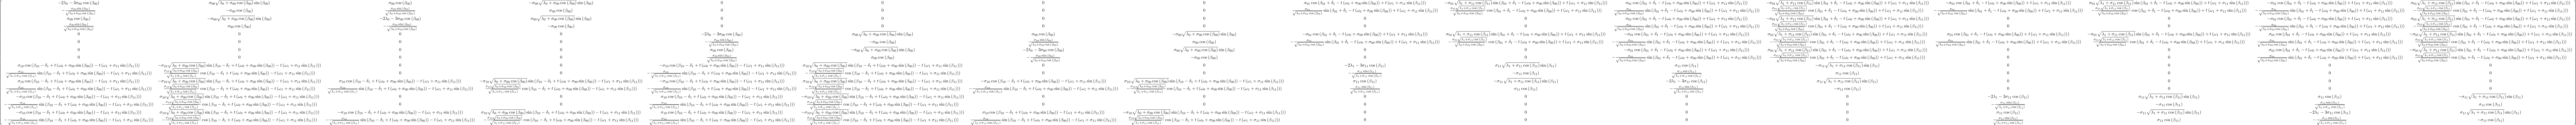

In [11]:
decoupled.jacobian

In [746]:
mymap, mins, maxs = generate_plots('A')

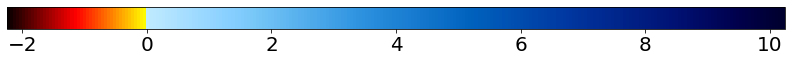

In [747]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(12, 2))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mymap
norm = mpl.colors.Normalize(vmin=mins, vmax=maxs)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
font_size = 20 # Adjust as appropriate.
cb1.ax.tick_params(labelsize=font_size)
plt.savefig("colorbar.pdf", bbox_inches='tight')

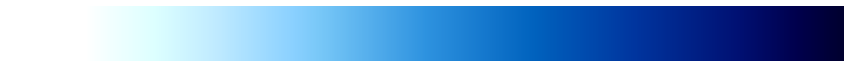

In [696]:
import matplotlib

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

dark_jet = cmap_map(lambda x: (x+.2)**2-.2, matplotlib.cm.Blues)

x, y = np.mgrid[1:2, 1:10:0.01]
plt.figure(figsize=[15, 1])
plt.imshow(y, cmap=dark_jet, aspect='auto')
plt.axis('off')
plt.show()

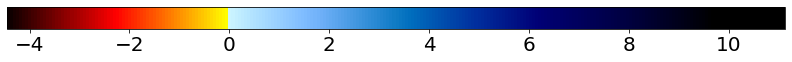

In [691]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(12, 2))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mymap
norm = mpl.colors.Normalize(vmin=mins, vmax=maxs)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
font_size = 20 # Adjust as appropriate.
cb1.ax.tick_params(labelsize=font_size)
plt.savefig("colorbar.pdf", bbox_inches='tight')

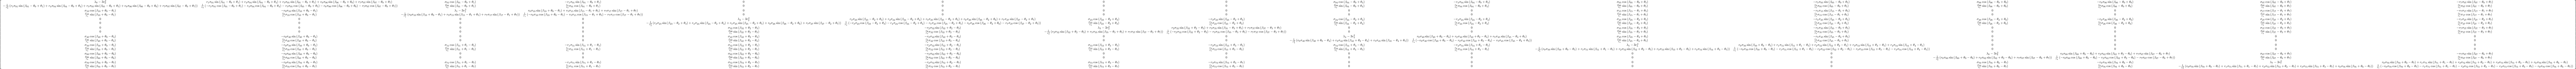

In [16]:
cube.jacobian

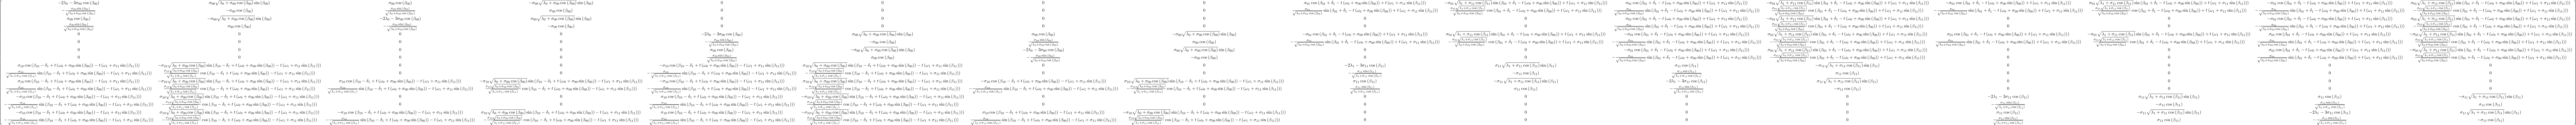

In [10]:
decoupled.jacobian

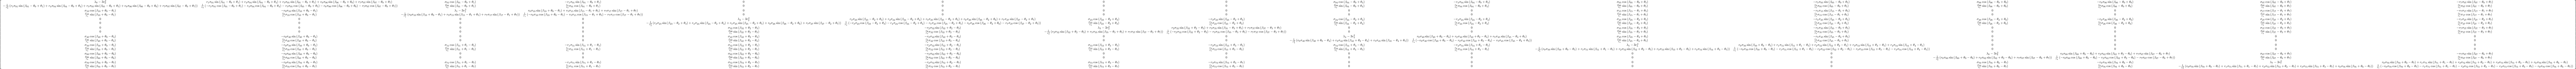

In [14]:
cube.jacobian

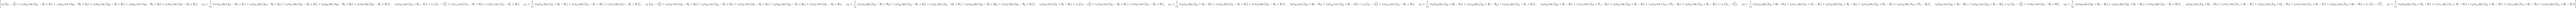

In [13]:
cube.dyn

KeyboardInterrupt: 

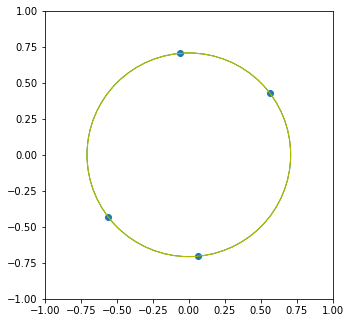

In [669]:
stability_anim = Stability('st', decoupled)

param_vals = {}
param_vals['delta']  = [np.pi/6] 
param_vals['beta']   = [[2, 1.5], [3, .8]]
param_vals['sigma']  = [[.5, 1.6], [.8, .7]]
param_vals['lambda'] = [0.5] * 2
param_vals['omega']  = [[0.7, 2.7]]

anim = stability_anim.animate(param_vals, decoupled)
HTML(anim.to_html5_video())